![header](https://drive.google.com/uc?id=1299mqN2JS7CxE05ca7elMc_5fvCc7vUn)


There are **7 parts** to this Notebook


1.   **Setup of the environment**
2.   **Implementation of the Policy Network**
3.   **Implementation of the REINFORCE Algorithm to train the Policy Network (Agent)**
4.   **Training of the Policy Network (Agent)**
5.   **Putting the Agent to work**
6.   **Conclusions**
7.   **Exercises and resources**



### **1- Setup of the environment**

[Link to OpenAI Gym environments](https://gym.openai.com/docs/): They are often used as a learning tool in Reinforcement learning. The `gym` python library contains a myriad of game environments to test RL algorithms on. 

In this tutorial, we are going to implement our own environment, but it is useful to understand how OpenAI Gym environments are built, because we are going to use similar underlying principles: 


1.   **Step() method**  | **Inputs:** action | **Outputs:** New state and reward
2.   **Reset() method** | **Inputs:** None   | **Outputs:** Initial state





 
![alt text](https://drive.google.com/uc?id=1FItFjMWIka8lxhqjTvce7dxH22ALSNaP)


The state definition is taken from this [article](https://drive.google.com/file/d/1xVQhH_emGHZOa7i8qsGj2j-IPiCb3ksO/view?usp=sharing) and defined as

$$ S_t = \begin{bmatrix}
    w_{1,t-1} & r_{1,t} & r_{1,t-1} & \dots  & r_{1, t-N} \\
    w_{2, t-1} & r_{2,t} & r_{2,t-1} & \dots  & r_{2,t-N} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    w_{M, t-1} & r_{M,t} & r_{M,t-1} & \dots  & r_{M,t-N}
\end{bmatrix}$$

* where $M$ and $N$ are the numbers of assets, and therefore the dimension of the action space, and the lenght of the lookback window respectively. 

* $w_i,t-1$ denotes the the weights invested in asset $i$ at the previous step. 

* $r_{i,t}$ denotes the return of asset $i$ at time $t$


In [ ]:
import numpy as np
import pandas as pd
import random

In [ ]:
class Env:
    def __init__(
              self, 
              data_path='data/datasets', 
              context='train', 
              index_col=None, 
              yearly_return=0.05, 
              T=252,
              lookback=30
              ):
      
        # -----------------------------------
        # INITIALIZING ENVIRONMENT VARIABLES
        # -----------------------------------
        # training or testing context
        if context == 'train':
            self.returns = pd.read_csv(data_path+'/train.csv', index_col=0)
            self.returns = self.returns[~(self.returns == 0).any(axis=1)]
            
        elif context == 'test':
            self.returns = pd.read_csv(data_path+'/test.csv', index_col=0)
            self.returns = self.returns[~(self.returns == 0).any(axis=1)]

        self.assets_col = [c for c in self.returns.columns]

        self.n_assets = len(self.assets_col) # number assets that can be used to build portfolio
        self.n_actions = self.n_assets
        self.t = 0 # step tracker initialized at 0
        self.T = T # game length in number of steps
        self.lookback = lookback
        self.history_len = self.returns.shape[0]  # total lenght of dataset
        self.yearly_return = yearly_return
        self.target_return = yearly_return*(self.T/252)

        self.reset() # initializing game 
        

    def reset(self):
        """
          The reset function is used to reset the environment at its initial state
          it resets any tracker values to zero, as well as
          initial asset/portfolio/index values to 1
        """

        # randomize the episode
        self.start = int(random.uniform(0, self.returns.shape[0]-self.T-self.lookback))
        self.indices = np.array(range(self.start, self.start+self.T+self.lookback))

        self.t = 0 # step tracker
        self.prev_action = 0 # previous action set 0, because there are no previous actions
        self.IV = 1 # index initial value set to 1
        self.PV = 1 # portfolio initial value set to 1
        self.PV_balanced = 1
        self.AV = np.array([1]*self.n_assets) # asset initial values set to 1
        self.dates = self.returns.index[self.indices] # game dates

        # logging lists
        self.portfolio_returns = [] # to store portfolio returns
        self.index_returns = [] # to store index returns
        
        # assets initial state
        self.assets = self.returns.loc[self.dates[self.lookback], self.assets_col]

        # define state
        prev_weights = np.array([1./self.n_assets]*self.n_assets)
        prev_weights = prev_weights.reshape((prev_weights.shape[0], 1))
        past_returns = self.returns.loc[self.dates[:self.lookback], self.assets_col]
        past_returns = past_returns.values.T
        state = np.concatenate((prev_weights, past_returns), axis=1)
        self.state = state.flatten()
        
        self.n_states = self.state.shape[0] # state dimension

        return self.state



    # def step_index(self):
    #     """ 
    #       This functions takes the next index return values 
    #       relative to where the tracker is, and increments the index cumulative value
    #     """
    #     index = self.returns[self.index_col].values[self.t+self.start]
    #     # index = self.returns.loc[self.dates[self.t], self.index_col]
    #     self.IV = self.IV * (1+index)
    #     return index



    def step_assets(self):
        """ 
          This functions takes the next assets return values 
          relative to where the tracker is, and increments the assets cumulative values
        """
        # set the return of assets and compute assets cumulative value
        assets = self.returns[self.assets_col].values[self.t+self.start,:]
        self.AV = self.AV * (1+assets)
        return assets

    def step_state(self, action):
      # define states as per the equation defined earlier
        # previous weights/action
        prev_weights = np.array(action.detach().numpy())
        prev_weights = prev_weights.reshape((prev_weights.shape[0], 1))

        # past asset returns
        past_returns = self.returns.loc[self.dates[self.t:(self.t+self.lookback)], self.assets_col]
        past_returns = past_returns.values.T

        # concatenate previous weights and past asset returns
        state = np.concatenate((prev_weights, past_returns), axis=1)
        self.state = state.flatten()

        return self.state


    def get_reward(self):
        """ 
            IMPORTANT: 
            This function is responsible for rewarding our agent when 
            it performs the way we want it to and, 
            penalize our agent when it does not perform the way we want it to
        """
        # define reward as the log portfolio return and determine if episode is over
        reward = np.log(1+self.portfolio_return)
        done = True if self.t == self.T else False

        return reward, done



    def step(self, action=None):
        """ 
            This function puts everything together.
            Based on a current state, and an action the agent has taken, it determines
            the next state the agent will find itself in.
        """
        # step index - get index return
        # self.index = self.step_index()
        # self.index_returns.append(float(self.index))

        # step assets - get assets returns
        self.assets = self.step_assets()
        self.t += 1

        # get portfolio return
        self.portfolio_return = np.dot(action.detach().numpy(), self.assets)
        self.portfolio_returns.append(float(self.portfolio_return))
        self.PV = self.PV * 1+self.portfolio_return
        self.PV_balanced = self.PV_balanced * (1+np.mean(self.assets))

        # get new
        self.state = self.step_state(action)

        # get reward
        reward, done = self.get_reward()

        return self.state.flatten(), reward, done


### **2 - Implementation of the Policy Network**

The basic policy network architecture follows the same [article](https://drive.google.com/file/d/1xVQhH_emGHZOa7i8qsGj2j-IPiCb3ksO/view?usp=sharing) stated earlier. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class Policy(nn.Module):
    def __init__(self, n_inputs, n_neurons, n_actions): 
        super(Policy, self).__init__()
        self.h1 = nn.Linear(n_inputs, n_neurons[0])
        self.h2 = nn.Linear(n_neurons[0], n_neurons[1])
        self.h3 = nn.Linear(n_neurons[1], n_neurons[2])
        self.out = nn.Linear(n_neurons[2], n_actions)

    def forward(self, state):
        # first layer
        x = F.relu(self.h1(state))
        # second layer
        x = F.relu(self.h2(x))
        # third layer
        x = F.relu(self.h3(x))
        # ouput action
        weights = F.softmax(self.out(x), dim=1)

        return weights

    def save(self, model_path):
      
        checkpoint = {
            'model_state_dict': self.state_dict()
        }
        torch.save(checkpoint, model_path)

    def load(self, model_path):
    
        checkpoint = torch.load(model_path)
        self.load_state_dict(checkpoint['model_state_dict'])
        return self 



### **3 - Implementation of the REINFORCE Algorithm to train the Policy Network (Agent)**

Let's review the REINFORCE Algorithm from Sutton and Barto (2018):

![reinforce](https://drive.google.com/uc?id=1vIcnCmRt-ol30BNBo4D328-jBQnIIACn)


Let's also view the REINFORCE Algorithm adapted to our use case from the same [article](https://drive.google.com/file/d/1xVQhH_emGHZOa7i8qsGj2j-IPiCb3ksO/view?usp=sharing) stated earlier.

![reinforce2](https://drive.google.com/uc?id=1xVhYBx-KEFE7te0pdUTd2WN_7PdTLEo6)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.nn.utils as utils
import pandas as pd

In [ ]:
class REINFORCE:
    def __init__(self, n_neurons, T, learning_rate, mode='training', path=None):
        # instantiate environments
        self.env_train = Env(context='train', T=T)
        self.env_test = Env(context='test', T=T)

        # instantiate the policy
        if mode == 'training':
            self.policy = Policy(self.env_train.n_states, n_neurons, self.env_train.n_actions)
        elif mode == 'predicting':
            self.policy = Policy(self.env_train.n_states, n_neurons, self.env_test.n_actions)
            print(path)
            self.policy.load(path)
        else: 
            print('Warning: Provide mode to instantiate policy or load existing one')

        # create an optimizer
        self.optimizer = torch.optim.Adam(self.policy.parameters())

    def train_agent(self, gamma, n_train_iterations, n_test_episodes, n_train_trajectories):
        """ This function follows the REINFORCE Algorithm defined earlier. 
            For every training iteration, it generates training episodes and
            accumulates the policy loss, 
            then it updates the policy network
            evaluate the progress and print some evaluation metrics
        """
        # logging list and values
        logs = {'losses': [],'train': [],'test': [], 'balanced': []}
        prev_avg_PV_test = 0
        best_avg_PV_test = 0

        # start training
        for iteration in range(n_train_iterations):
            # play episode with current policy
            policy_loss = 0
            for i in range(n_train_trajectories):
                _, _, rewards, _, _ = self.generate_episode(env='train')
                policy_loss += 1/n_train_trajectories * self.get_policy_loss(rewards)

            # update policy
            policy_loss = self.update_policy(policy_loss) 

            # evaluate policy
            avg_PV_train, avg_PV_test, avg_PV_balanced = self.evaluate_policy(n_test_episodes=n_test_episodes)

            # log metrics
            logs['losses'].append(policy_loss.detach().numpy())
            logs['train'].append(avg_PV_train)
            logs['test'].append(avg_PV_test)
            logs['balanced'].append(avg_PV_balanced)

            # print progress
            print("Episode: {}\t Loss (train): {} \t| REINFORCE (train): {} \t| REINFORCE (test): {} \t| Balanced (test): {} \t| Best REINFORCE (test): {}".format(
                                    iteration, 
                                    np.round(np.mean(np.array(policy_loss.detach().numpy()))*100,2),
                                    np.round(avg_PV_train*100,2), 
                                    np.round(avg_PV_test*100,2), 
                                    np.round(avg_PV_balanced*100,2), 
                                    np.round(best_avg_PV_test*100,2))
                                    )

            if prev_avg_PV_test < avg_PV_test:
                model_save_name = 'policy_network.pt'
                # note that you will have to change this path according to your own Google Drive and where the directory is saved!
                path = F"/content/gdrive/My Drive/Portfolio Design using Reinforcement Learning/Notebooks/FINAL/models/{model_save_name}" 
                self.policy.save(path)
            
            if best_avg_PV_test < avg_PV_test:
                best_avg_PV_test = avg_PV_test
            
            prev_avg_PV_test = avg_PV_test


        return logs

    def evaluate_policy(self, n_test_episodes):
        """ This method evaluates the policy network on the train and test environment
        """
        # instantiate metrics
        avg_PV_train, avg_PV_test, avg_PV_balanced = 0, 0, 0

        # start evaluation by playing episodes
        for i in range(n_test_episodes):
            # play episode on train and test
            self.generate_episode(env='train')
            self.generate_episode(env='test')

            # accumulate evaluation metrics
            avg_PV_train += 1/n_test_episodes * self.env_train.PV
            avg_PV_test += 1/n_test_episodes * self.env_test.PV
            avg_PV_balanced += 1/n_test_episodes * self.env_test.PV_balanced
          
        return avg_PV_train, avg_PV_test, avg_PV_balanced


    def select_action(self, state):
        """ This method returns the action given a state
        """
        # pass the state to the policy network to get the next action
        action = self.policy(torch.tensor(state).unsqueeze(0).float())

        return action

    def get_policy_loss(self, rewards):
        """ This method returns the policy loss
        """
        return -1/len(rewards) * sum(rewards)

    def update_policy(self, policy_loss): 
        """ This method updates the weights of the policy network
        """
        # backpropagate and update network
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        return policy_loss


    def generate_episode(self, env):
        """ This method generates an episode given an environment and using the 
            current policy network
        """
        # instantiate lists
        rewards = []
        actions = []
        states  = []
        PV, PV_balanced = [], []

        # reset environment
        state = self.env_train.reset() if env == 'train' else self.env_test.reset()
 
        while True:
            # calculate probabilities of taking each action
            action = self.select_action(state)
            assets = torch.tensor(self.env_train.assets).float() if env == 'train' else torch.tensor(self.env_test.assets).float()
            # assets = torch.tensor(env.assets).float()
            action = action.squeeze(0).float()
            portfolio = torch.dot(assets, action)

            # use that action in the environment
            # new_state, _, done = env.step(action)
            new_state, _, done = self.env_train.step(action) if env == 'train' else self.env_test.step(action)

            # store state, action and reward
            states.append(state)
            actions.append(action.tolist())
            rewards.append(portfolio)

            state = new_state

            PV.append(self.env_test.PV)
            PV_balanced.append(self.env_test.PV_balanced)

            if done:
                break

        return states, actions, rewards, PV, PV_balanced


### **4 - Training of the Policy Network (Agent)**

The purpose of the 3 first cells of this section is to mount the google drive to access the train and test data.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader

In [ ]:
GoogleDriveDownloader.download_file_from_google_drive(file_id='1AaT00j4Usj4BXmjJMLNBcoiuQ1ZPJQvG', dest_path='data/datasets/train.csv', unzip=False)
GoogleDriveDownloader.download_file_from_google_drive(file_id='1Qp9GRt0Q9trH3JBCzqNfahHiL5MYYSB_', dest_path='data/datasets/test.csv', unzip=False)

In [12]:
from google.colab import drive
drive.mount('/data/datasets/')

ValueError: ignored

This next part create a instance of the REINFORCE agent and then trains the agent using the `train_agent` method.
As per this code, 
* the policy network has 3 layers of 256 neurons each;
* the lenght of each episode is 90 days;
* the learning rate is 0.0001;
* the discount factor is set to 0.99;
* The number of training iterations is set to 2000;
* the evaluation metrics on the test and train set are computed over 10 episodes;
* the loss function is computed over 100 episodes at each iteration of the training.


In [ ]:
reinforce_agent = REINFORCE(
                    n_neurons=[256, 256, 256],
                    T=90, 
                    learning_rate=0.0001
                    )

logs = reinforce_agent.train_agent(
                    gamma=0.99, 
                    n_train_iterations=2000, 
                    n_test_episodes=10,
                    n_train_trajectories=100
                    )

Episode: 0	 Loss (train): -0.01 	| REINFORCE (train): 105.2 	| REINFORCE (test): 95.65 	| Balanced (test): 95.22 	| Best REINFORCE (test): 0


RuntimeError: ignored

### **5 - Putting the Agent to work**
In this section
* we are going to create a new instance of the REINFORCE agent, but this time using the trained policy network in predicting mode.
* we then generate 10 test episodes and plot the agent's portfolio value at each time step against a balanced portfolio. 
* last, we plot an example of portfolio allocation for an entire episode

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model_save_name = 'policy_network.pt'
# note that you will have to change this path according to your own Google Drive and where the directory is saved!
path = F"/content/gdrive/My Drive/Portfolio Design using Reinforcement Learning/Notebooks/FINAL/models/{model_save_name}" 

In [ ]:
# instantiate the agent in predicting mode, using the trained model
reinforce_agent = REINFORCE(
                  n_neurons=[256, 256, 256],
                  T=90, 
                  learning_rate=0.0001,
                  mode='predicting',
                  path=path
                  )

/content/gdrive/My Drive/Portfolio Design using Reinforcement Learning/Notebooks/FINAL/models/policy_network.pt


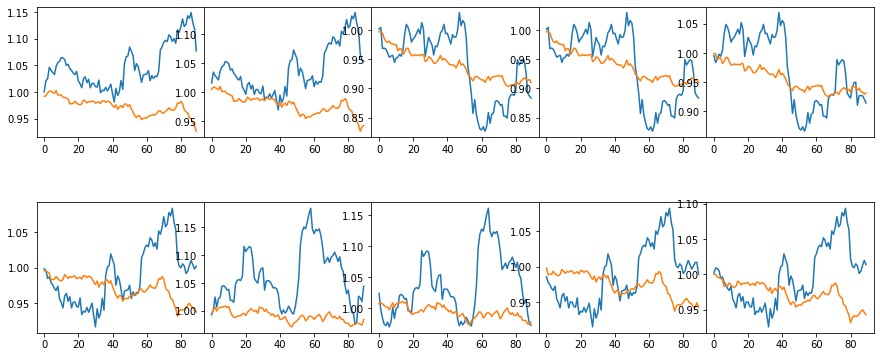

In [ ]:
# run some test episodes to see how the agent is performing
PVs = []
PVs_balanced = []
for i in range(10):
  states, actions, rewards, PV, PV_balanced = reinforce_agent.generate_episode(env='test')
  PVs.append(PV)
  PVs_balanced.append(PV_balanced)

PV = pd.DataFrame(PVs).T
PV_balanced = pd.DataFrame(PVs_balanced).T

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(10):
  axs[i].plot(PV.iloc[:,i])
  axs[i].plot(PV_balanced.iloc[:,i])

plt.show()

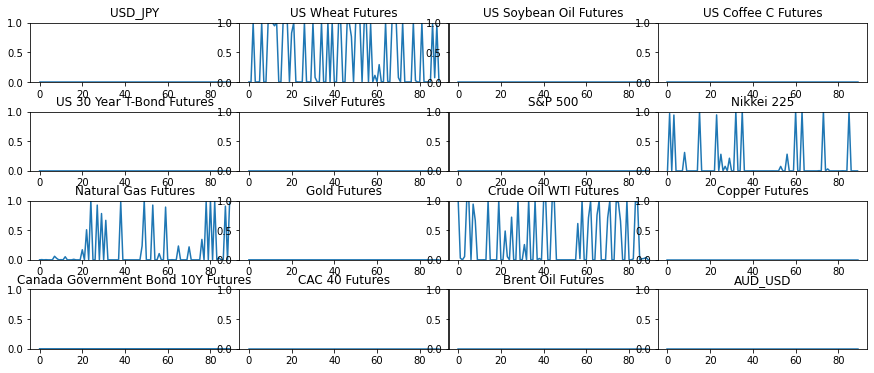

In [ ]:
# plot portfolio allocations
col_names = reinforce_agent.env_test.assets_col
fig, axs = plt.subplots(4,4, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
plt.setp(axs,ylim=(0,1))
axs = axs.ravel()
actions = pd.DataFrame(actions, columns=col_names)

for i in range(16):
  axs[i].plot(actions.iloc[:,i])
  axs[i].title.set_text(col_names[i])

plt.show()

### **6 - Conclusions**

We have reached the end of the Notebook.


1.   We learned how to setup an custom environment by following OpenAI gym environments principles.
2.   We implemented the policy network; a standard multilayer perceptron 
3.   We implemented the REINFORCE algorithm according to our specific objective: maximizing the portfolio returns.
4. We trained the agent for 200 training iterations.
5. We ploted 10 testing episodes portfolio value and saw that on average the REINFORCE agent does better than the balanced portfolio.
6. We saw that the agent chooses high performing assets, that happened to be high variance as well. 
7. We also saw that the porfolio allocation varies a lot which could lead to high transaction costs. 



### **7 - Exercises and resources**

**Exercices** you can try:


1.   Change the **objective** of the agent: how would you adapt the code to hit a specific return rather than maximize the total return?
2.   Try imposing additional **constraints** on the agent. For example, how would you adapt the code to limit the transaction costs? Or, how would you adapt the code to limit the variance of the returns?
3. We used a standard multilayer perceptron as the policy network, one way to improve the performance of the agent could be to try **other types of networks** like LSTMs, GRUs, or CNNs.
4. Try playing with the **hyperparameters**. The only parameter that was tuned for this Notebook is the learning rate. You could try to play with the number of hidden layers, and neurons, the episode lenght, etc. 



Finally, here is another interesting [article](https://drive.google.com/file/d/1cXBsu1ETpxXF4dMhr-vTcLWfMUFzILiP/view?usp=sharing) on porfolio allocation you might want to look into if you are interested. 


